In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re

# initialize a dict to store the data
llm_performance = {
    "GPT": {"IMDB": 0.9415, "ISEAR": 0.70345, "FEVER": 0.7998},
    "LLAMA": {"IMDB": 0.93332, "ISEAR": 0.6823, "FEVER": 0.7715}
}

In [19]:
llm_name = 'GPT'
dataset_name = 'IMDB'
paper_log_dir = f"./paper_logs/{llm_name}/{dataset_name.lower()}-{llm_name.lower() if llm_name == 'LLAMA' else llm_name}-small/"

# get all .log files in the directory
files = [f for f in os.listdir(paper_log_dir) if f.endswith('.log')]
files.sort()
# divide the files into different cascade sizes
paper_cascades = {}
for f in files:
    cascade_size = f.split('_')
    if '_'.join(cascade_size[0:-1]) not in paper_cascades:
        paper_cascades['_'.join(cascade_size[0:-1])] = []
    paper_cascades['_'.join(cascade_size[0:-1])].append(f)
paper_cascades

{'LR_BERT-base': ['LR_BERT-base_0.00001.log',
  'LR_BERT-base_0.00003.log',
  'LR_BERT-base_0.00005.log',
  'LR_BERT-base_0.00007.log',
  'LR_BERT-base_0.00009.log',
  'LR_BERT-base_0.00010.log',
  'LR_BERT-base_0.00011.log',
  'LR_BERT-base_0.00013.log',
  'LR_BERT-base_0.00015.log',
  'LR_BERT-base_0.00017.log',
  'LR_BERT-base_0.00019.log',
  'LR_BERT-base_0.00020.log',
  'LR_BERT-base_0.00030.log',
  'LR_BERT-base_0.00040.log',
  'LR_BERT-base_0.00050.log',
  'LR_BERT-base_0.00060.log',
  'LR_BERT-base_0.00070.log',
  'LR_BERT-base_0.00080.log',
  'LR_BERT-base_0.00090.log'],
 'LR_BERT-base_BERT-large': ['LR_BERT-base_BERT-large_0.000001.log',
  'LR_BERT-base_BERT-large_0.000002.log',
  'LR_BERT-base_BERT-large_0.000003.log',
  'LR_BERT-base_BERT-large_0.000004.log',
  'LR_BERT-base_BERT-large_0.000005.log',
  'LR_BERT-base_BERT-large_0.000006.log',
  'LR_BERT-base_BERT-large_0.000007.log',
  'LR_BERT-base_BERT-large_0.000008.log',
  'LR_BERT-base_BERT-large_0.000009.log',
  'LR_BE

In [20]:
rebuttal_log_dir = f"./logs/rebuttal/ds_category/{llm_name.lower()}/{dataset_name.lower()}/"

# get all .log files in the directory
files = [f for f in os.listdir(rebuttal_log_dir) if f.endswith('.log')]
files.sort()
# divide the files into different cascade sizes
cascades = {}
for f in files:
    cascade_size = f.split('_')
    if '_'.join(cascade_size[0:-1]) not in cascades:
        cascades['_'.join(cascade_size[0:-1])] = []
    cascades['_'.join(cascade_size[0:-1])].append(f)
cascades

{'LR_BERT-base': ['LR_BERT-base_0.00001000.log',
  'LR_BERT-base_0.00003000.log',
  'LR_BERT-base_0.00005000.log',
  'LR_BERT-base_0.00007000.log',
  'LR_BERT-base_0.00009000.log',
  'LR_BERT-base_0.00011000.log',
  'LR_BERT-base_0.00013000.log',
  'LR_BERT-base_0.00015000.log',
  'LR_BERT-base_0.00017000.log',
  'LR_BERT-base_0.00019000.log',
  'LR_BERT-base_0.00020000.log',
  'LR_BERT-base_0.00030000.log',
  'LR_BERT-base_0.00040000.log',
  'LR_BERT-base_0.00050000.log',
  'LR_BERT-base_0.00060000.log',
  'LR_BERT-base_0.00070000.log',
  'LR_BERT-base_0.00080000.log',
  'LR_BERT-base_0.00090000.log']}

In [17]:
def plot_figure(cascade_logs, paper_logs):
    plt.rcdefaults()
    # define figure size
    plt.figure(figsize=(6, 4.5))
    plt.rcParams["font.weight"] = "bold"
    # bold the x and y axis labels
    plt.rcParams["axes.labelweight"] = "bold"

    cascade_size = len(cascade_logs[0].split('_')) - 1
    print("cascade size: ", cascade_size)

    def get_stats(logs, log_dir):
        costs = []
        accus = []
        linear_accus = []
        # plot the data
        for f in logs:
            num_lines = sum(1 for line in open(log_dir + f))
            # read last line of the file
            with open(log_dir + f, 'r') as file:
                last_line = file.readlines()[-2]
            # data format: '''m1_prediction, m2_prediction, ..., llm_prediction, ground_truth, m1_proportion, m2_proportion, ..., m1_defer_prob, m2_defer_prob, ..., m1_score, m2_score, ..., m1_accuracy, m2_accuracy, llm_accuracy, overall_accuracy'''
            data = re.split(',', last_line.strip())
            model_prop = []
            linear_combination_acc = 0
            for k in range(cascade_size):
                model_prop.append(float(data[k + cascade_size + 2]))
                linear_combination_acc += float(data[k + cascade_size * 4 + 2]) * float(data[k + cascade_size + 2])
                
            llm_cost = 1 - sum(model_prop)
            model_accu = []
            for k in range(cascade_size):
                model_accu.append(float(data[k + cascade_size * 4 + 2]))
            llm_accuracy = float(data[k + cascade_size * 4 + 3])
            overall_accuracy = float(data[k + cascade_size * 4 + 4])
            linear_combination_acc += llm_accuracy * llm_cost

            costs.append(llm_cost * num_lines)
            accus.append(overall_accuracy)
            linear_accus.append(linear_combination_acc)
        return costs, accus, linear_accus
    
    rebuttal_costs, rebuttal_accus, rebuttal_linear_accus = get_stats(cascade_logs, rebuttal_log_dir)
    paper_costs, paper_accus, paper_linear_accus = get_stats(paper_logs, paper_log_dir)
        
    def postprocessing(costs, accus, linear_accus):
        costs = np.array(costs)
        accus = np.array(accus)
        idx = np.argsort(costs)
        costs = costs[idx]
        accus = accus[idx]
        linear_accus = np.array(linear_accus)
        linear_accus = linear_accus[idx]
        return costs, accus, linear_accus

    rebuttal_costs, rebuttal_accus, rebuttal_linear_accus = postprocessing(rebuttal_costs, rebuttal_accus, rebuttal_linear_accus)
    paper_costs, paper_accus, paper_linear_accus = postprocessing(paper_costs, paper_accus, paper_linear_accus)

    print(sum(rebuttal_accus) / len(rebuttal_accus))
    print(sum(paper_accus) / len(paper_accus))
    print(sum(rebuttal_accus) / len(rebuttal_accus) - sum(paper_accus) / len(paper_accus))

    plt.plot(rebuttal_costs, rebuttal_accus, label = 'OCL, with Distribution Shift (Category)', color='tab:blue', linestyle='dotted')
    plt.plot(paper_costs, paper_accus, label = 'OCL, without Distribution Shift (Category)', color='tab:blue')
    
    plt.plot(rebuttal_costs, rebuttal_linear_accus, label = 'OEL, with Distribution Shift (Category)', color='tab:orange', linestyle='dotted')
    plt.plot(paper_costs, paper_linear_accus, label = 'OEL, without Distribution Shift (Category)', color='tab:orange')

    # add llm as a horizontal dotted line
    plt.axhline(y=llm_performance[llm_name][dataset_name], color='g' if llm_name == 'LLAMA' else 'r', linestyle='--', label = 'LLAMA 2' if llm_name == 'LLAMA' else 'GPT 3.5 Turbo')
    
    plt.xlabel('Cost Budget (number of LLM calls)', fontsize=16, weight='bold')
    plt.title(dataset_name, weight='bold', fontsize=20)

    # set the y-axis range
    start_range = 0.7 if llm_name == 'LLAMA' else 0.5
    plt.ylim([start_range, 1])
    plt.legend(loc='lower right', fontsize=10)

    # write to pdf file
    size = "small" if cascade_size == 2 else "large"
    plt.savefig("rebuttal_ds_cate_" + dataset_name + '_' + size + '_' + llm_name + '_cascade.pdf', bbox_inches='tight')
    plt.show() 

cascade size:  2
0.9085666666666666
0.9077421052631579
0.0008245614035087279


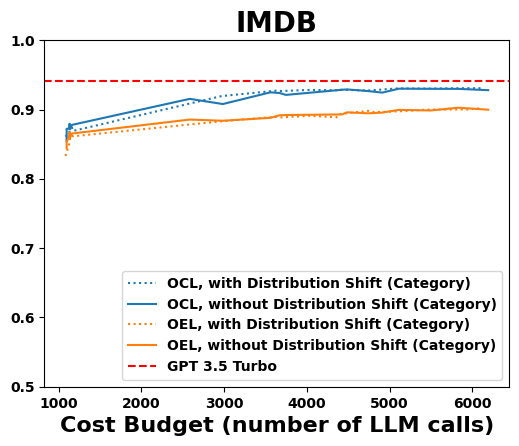

In [21]:
cascade_name = 'LR_BERT-base'
cascade_logs = cascades[cascade_name]
cascade_costs = {
    "gpt": [1, 1182],
    "llama": [1, 636]
}

plot_figure(cascade_logs, paper_cascades[cascade_name])